In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import lang2vec.lang2vec as l2v
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
import numpy as np
import umap.plot

from uriel import Uriel
from visualizations import show_weights
from papers import papers

In [6]:
u = Uriel(load=True, umap=True)

# Different similarity measures

I implemented three similarity measures: Euclidean similarity, cosine similarity and Jaccard-like similarity. From these cosine similarity seems to be the best. It seems to be the most stable, other measure have some artifacts (e.g. see scores for French or difference between Arabic and Hebrew).

In [16]:
from visualizations import show_weights

languages = papers['rahimi_ner'][0]
show_weights(u, u.weights(languages, temperature=15, distance='cos'))
show_weights(u, u.weights(languages, temperature=1, distance='euc'))
show_weights(u, u.weights(languages, temperature=15, distance='jac'))

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [24]:
# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
from bokeh.io import output_notebook, push_notebook, show

weights = u.weights(languages, temperature=10, distance='cos')
max_ = max(weights.values())
metadata = u.language_metadata(u.uriel_languages)
p = umap.plot.interactive(
    u.umap_vectors,
    hover_data=metadata,
    width=400,
    height=400,
    interactive_text_search=True,
    point_size=1,
    interactive_text_search_alpha_contrast=0.99,
)
metadata = metadata[metadata['code'].isin(weights)]
metadata = metadata.assign(
    x=u.umap_vectors.embedding_[metadata.index][:,0],
    y=u.umap_vectors.embedding_[metadata.index][:,1],
    width=0.05,
    height=[weights[l]*5/max_ for l in metadata['code']],
    alpha=1,
)
metadata['y'] += metadata['height'] / 2
p.children[1].rect(
    x='x',
    y='y',
    width='width',
    height='height',
    color="#ee6666",
    source=metadata,
)

output_notebook()
weights = {
    val:  u.weights(languages, temperature=val, distance='cos')
    for val
    in range(21)
}

@interact(x=(0, 20))
def update(x):
    max_ = max(weights[x].values())
    p.children[1].renderers[1].data_source.data['height'] = [
        weights[x][l]*5/max_
        for l
        in metadata['code']
    ]
    show(p)

Loading BokehJS ...

interactive(children=(IntSlider(value=10, description='x', max=20), Output()), _dom_classes=('widget-interact'…

In [35]:
from matplotlib.collections import LineCollection

def compare_approaches(languages, scores, weights, families):
    """
    scores = L x M
    weights = 1 x L
    """
    xs = weights @ scores
    in_mask = np.array([bool(u.lang_fams[l] & families) for l in languages])
    ys_in = in_mask / np.sum(in_mask) @ scores
    ys_out = ~in_mask / np.sum(~in_mask) @ scores
     
    fig, axes = plt.subplots(1, 2)
    for ax, ys in zip(axes, [ys_in, ys_out]):
        col = LineCollection(segments=[[(0,0), (100,100)]], linewidths=1, colors='b')
        ax.add_collection(col, autolim=False)
        ax.scatter(xs, ys, c='r', s=2)
        for i, xy in enumerate(zip(xs, ys)):     
            ax.annotate(
                text=i,
                xy=xy,
                xytext=(1, 1),
                textcoords='offset points',
                ha='right',
                va='bottom',
                fontsize='xx-small')
    fig.show()
    
languages, scores = papers['rahimi_ner']
    
weights = {
    x: u.weights(languages, temperature=x)
    for x
    in range(-20, 21)
}

@interact(temp=(-20, 20))
def change(temp):
    compare_approaches(languages, scores, np.array(list(weights[temp].values())), set(['Germanic', 'Slavic', 'Italic']))
    

interactive(children=(IntSlider(value=0, description='temp', max=20, min=-20), Output()), _dom_classes=('widge…

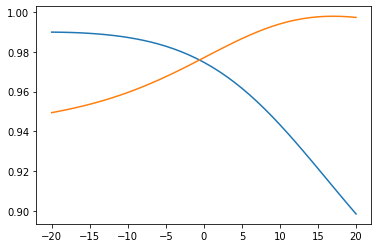

In [31]:
from scipy.stats import pearsonr

languages, scores = papers['rahimi_ner']
# languages, scores = papers['heinzerling_pos']
families = set(['Germanic', 'Slavic', 'Italic'])

in_buf = []
out_buf = []
for temperature in range(-20, 21):
    weights = np.array(list(u.weights(languages, temperature=temperature).values()))
    xs = weights @ scores
    in_mask = np.array([bool(u.lang_fams[l] & families) for l in languages])
    ys_in = in_mask / np.sum(in_mask) @ scores
    ys_out = ~in_mask / np.sum(~in_mask) @ scores
    in_buf.append(pearsonr(xs, ys_in)[0])
    out_buf.append(pearsonr(xs, ys_out)[0])

plt.plot(range(-20, 21), in_buf)
plt.plot(range(-20, 21), out_buf)